# Equidistant Projection with the Help of the Pinhole Camera Model

In this code, we try to make a photograph from a 3D cube. This time, we do not use the perspective projection model but the equidistant projection model. At the end, the cube should be deformed by the equidistant projection model. You should see alot of curved edges...

Please insert your code where it is asked for ("insert your code here").

## Building up the 3D Environment and Defining Some Functions

In [19]:
import numpy as np
import matplotlib.pyplot as plt


# Our 3D world contains a 3D cube
xx = np.linspace(-1, 1, 10)
yy = np.linspace(-1, 1, 10)
zz = np.linspace(-1, 1, 10)
x, y, z = np.meshgrid(xx, yy, zz)

num_points = x.shape[0] * x.shape[1] * x.shape[2]
print("number of points:", num_points)

x = x.reshape((1, num_points))
y = y.reshape((1, num_points))
z = z.reshape((1, num_points))
w = np.ones_like(x, dtype=np.float)

X_wcs = np.concatenate((x, y, z, w), axis=0)

#activate intermediate result validation:
validation = True # deactivate with False
debug = False # False to suppress some annoying prints...

# simply ignore this method:
def validate(array, hash_val, error_msg):
    if validation == False:
        return # do not validate
    if type(array) != np.ndarray:
        s = hash(array)
    else:
        s = 0
        for i in range(array.shape[0]):
            for j in range(array.shape[1]):
                s += hash(array[i, j] * 7*(i+1) + 13*(j+1))
    
    if debug == True:
        print("hash was:", s)
    assert s == hash_val, error_msg
            

number of points: 1000


## Extrinsic Parameters
Let's define the position $C$ of the camera.

In [20]:
C = np.array([[0.5, -2, 1.5]])
C = C.T
print(C)
assert(C.shape == (3,1))

[[ 0.5]
 [-2. ]
 [ 1.5]]


Now it's time to build up the rotation matrix s.th. the camera looks into the direction of the cube...  
For the sake of simplicity, please rotate only about the x axis around 90 degrees.  
Hint: Numpy's trigonometric functions take angles in radians not in degrees.

In [21]:
# rotate around x axis about 90 degrees
# provide the angle in radians:
alpha_in_rad = 90 * np.pi / 180.0 # insert your code here

validate(alpha_in_rad, 1316166719824867329, "alpha was not correctly translated to radians")

# calculate the cosine and sine value of alpha
c = np.cos(alpha_in_rad)
s = np.sin(alpha_in_rad)

# now build up the inhomogeneous 3D rotation matrix around the z axis with the help of the veriables c and s.
# insert your code here:
R = np.array([
    [1, 0,  0],
    [0, c, -s],
    [0, s,  c]
], dtype=np.float)

validate(R, 248, "The rotation matrix is not correct.")

The homography that converts a point from world coordinate system to camera coordinate system is defined as:  
$H = \begin{pmatrix}
R & -RC \\
\it{\bf{0}}^T & 1
\end{pmatrix}$

In [22]:
# Please build up the upper three rows [R -RC] with the help of np.concatenate(). Which concatenation axis is the right?
RC = R.dot(C)
H_top = np.concatenate((R, -RC), axis=1) # insert your code here
validate(H_top.shape, 3713083796997400956, "The shape of your H_top is wrong! The shape is: " + str(H_top.shape))
validate(H_top[:,1:], 1152921504606847276, "This is not the right translation part.")
validate(H_top, 1152921504606847439, "Hmm, seems to be not the desired H_top...")

# Now build up the lower row of. Which shape has lower row? Hint: How many colums has R?
H_bottom = np.array([[0, 0, 0, 1]], dtype=np.float) # insert your code here
validate(H_bottom.shape, 3713081631940905806, "The shape of your H_bottom is wrong! The shape is: " + str(H_bottom.shape))
validate(H_bottom, 137, "Hmm, seems to be not the desired H_bottom...")

# Now concatenate H_top and H_bottom
H = np.concatenate((H_top, H_bottom), axis=0) # insert your code here

# Convert X_wcs to X_ccs
X_ccs = H.dot(X_wcs) # insert your code here
validate(X_ccs, 2767011611056508334380, "This are not the right homogeneous coordinates for X in CCS.")

# make it inhomogeneous
X_ccs_inhom = X_ccs[:3,:] / X_ccs[3,:] # insert your code here
validate(X_ccs_inhom, 2767011611056501799880, "The convertion to inhomogeneous space is wrong.")
print(X_ccs_inhom.shape)

(3, 1000)


## Intrinsic Parameters

In [23]:
w = 1024 # image width
h = w # image height is image width

c_x = (w + 1) / 2.0 # insert your code here
c_y = (h + 1) / 2.0 # insert your code here
validate(c_x + 10, 1152921504606847498, "This is not the desired c_x")
validate(c_y + 20, 1152921504606847508, "This is not the desired c_y")


# let's directly define the focal length in pixel space:
f = w / np.pi

Let $X_\text{ccs}'$ be the orthogonal projection of $X_\text{ccs}$ on the cameras x-y-plane.  
Then, $X_\text{ccs}'$ is the same as $X_\text{ccs}$ but has $z=0$ for all points.  
The azimuth $\varphi$ of $X_\text{ccs}$ can be computed by measuring the angle between $X_\text{ccs}'$ and the x-axis of the camera.

In [24]:
x_axis = np.array([[1, 0, 0]], dtype=np.float).T
X_ccs_proj = np.copy(X_ccs_inhom)
X_ccs_proj[2,:] = 0
all_phis = np.zeros((1, num_points))
for i in range(num_points):
    current_point = X_ccs_proj[:,i] # insert your code here
    validate(current_point.shape, 3430021387564, "Please extract a column vector from X_ccs_proj")
    euclidean_length = np.linalg.norm(current_point)
    cos_val = (current_point.T).dot(x_axis) / euclidean_length
    phi = np.arccos(cos_val)
    if current_point[1] < 0:
        phi = 2 * np.pi - phi
    all_phis[0, i] = phi

# unit vector u_r (conf. Chapt 4, slide 24)
u_r_top = np.cos(all_phis) # insert your code here
validate(u_r_top, 1164609820778619375238, "This is not the desired top (row) for u_r. Have you considered all phi values?")
u_r_bottom = np.sin(all_phis) # insert your code here
validate((u_r_bottom.T*7+15), 1126625615689891267539, "This is not the desired bottom (row) for u_r. Have you considered all phi values?")
u_r = np.concatenate((u_r_top, u_r_bottom), axis=0)



The elevation $\theta$ can be calculated by taking the angle between the vector to $X$ and the camera's z axis.

In [25]:
z_axis = np.array([[0, 0, 1]], dtype=np.float).T
all_thetas = np.zeros((1, num_points))
for i in range(num_points):
    current_point = X_ccs_inhom[:,i] # insert your code here
    validate(current_point.shape, 3430021387564, "Please extract a column vector from X_ccs_inhom")
    euclidean_length = np.linalg.norm(current_point)
    cos_val = (current_point.T).dot(z_axis) / euclidean_length
    theta = np.arccos(cos_val)
    all_thetas[0, i] = theta

## Projection
Now, let's do the projection with the help of the equidistant projection function: $\rho(\theta) = f \cdot \theta$

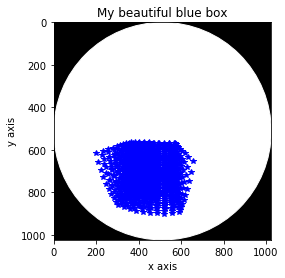

In [26]:
f_norm = 1 # focal length of normalized ICS is always 1
all_rhos = f_norm * all_thetas # insert you code here
validate(all_rhos, 1139176930484582078855, "This is not the correct result for rho.")
X_norm_inhom = u_r * all_rhos
X_norm = np.concatenate((X_norm_inhom, np.ones((1, num_points))), axis=0)

# insert your code here:
K = np.array([
    [f, 0, c_x],
    [0, f, c_y],
    [0, 0,   1]
], dtype=float)
validate(K, 3310712090126206405, "Apparently K was not built up properly. Have you used the right focal length?")

X_img = K.dot(X_norm) # insert your code here
validate(X_img, 2381745544193333413326, "X_img is wrong. Maybe you're not in homogeneous space?")
X_img_inhom = X_img[:2, :] / X_img[2]  # insert your code here
validate(X_img_inhom, 2381745544193326885826, "That are not the right inhomogeneous coordinates :/...")

# plotting NOT important for examination!
fig, ax = plt.subplots()
ax.set_title("My beautiful blue box")
ax.set_xlabel("x axis")
ax.set_ylabel("y axis")
plt.plot(X_img_inhom[0,:], X_img_inhom[1,:], 'b*')
ax.invert_yaxis()
ax.set_facecolor((0, 0, 0))
plt.xlim(left=0, right=w)
plt.ylim(top=0, bottom=h)
ax.set_aspect('equal', adjustable='box')
circle1 = plt.Circle((c_x, c_y), w/2, color='w')
ax.add_artist(circle1)


